# A quick example of using MAPS to search with square-root spherical harmonics

In [1]:
# If you are just testing this package without installing, you can add the package to the path
import sys
sys.path.insert(0,'..')
import maps
print('Using maps from', maps.__file__)

Using maps from /Users/kushagran.nag/IPTA_GWB/anisotropy/MAPS/MAPS/docs/../maps/__init__.py


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from maps import anis_pta as ap
from maps import utils

import numpy.random as rn
from enterprise.signals import anis_coefficients as ac
import pickle, corner
from la_forge import core, diagnostics

Optional mpi4py package is not installed.  MPI support is not available.


/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Generating data

For this test we will need to generate our own data. We skip many of the steps we might have to do with real data and instead assume that we have run through everything to the point of having pulsar correlations and pulsar correlation uncertainties.
- Note that while MAPS does support pair covariance, this example will not use it. To generate pair covariance matrices of you own, look into the optimal statistic code in [DEFIANT](https://github.com/GersbachKa/defiant).

For this example, we will generate 67 pulsars with random positions in the sky.

In [3]:
seed = 616 #choose a seed for random draws
rng = rn.default_rng(seed)

In [4]:
#Set configuration for square-root spherical harmonic search
lmax = 6 # The maximum l value to search in spherical harmonics
nside = 8 # Maximum nside for the healpy pixelization

n_psrs = 67 # The number of pulsars
n_cc = (n_psrs * (n_psrs-1))//2 # The number of pulsar pairs

print(f"Using {n_psrs} pulsars with {n_cc} pairs")

Using 67 pulsars with 2211 pairs


In [5]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = n_psrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = n_psrs))

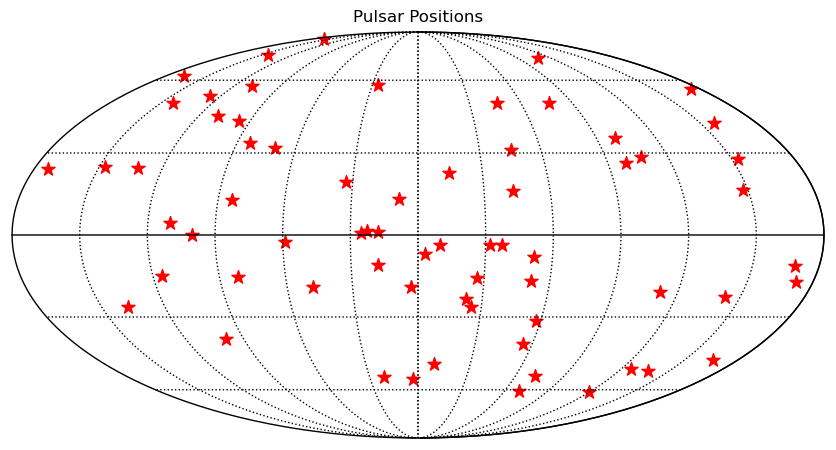

In [7]:
#Make figure here
hp.mollview(title = 'Pulsar Positions', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

### Creating the injection

For this test we will first generate an isotropic GWB, then add in a hotspot. We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at (lat = 45,long = 270) for which we increase the power.

Also, have a look at notebooks in ```./Bayesian_inference/``` to look at the use of a handy function ```inject_anisotropy``` in utils to create the injections with any basis. The function creates <span style="color:blue">injected</span> attributes of the anis_pta object which are very handy in post-processing specially in case of bayesian inference.

In [8]:
#Simulate an isotropic background plus a hotspot
input_map = np.ones(hp.nside2npix(nside))

lon = 270
lat = 45
vec = hp.ang2vec(lon, lat, lonlat=True)

radius = np.radians(10)

disk_anis = hp.query_disc(nside = nside, vec = vec, radius = radius, inclusive = False)

input_map[disk_anis] += 50

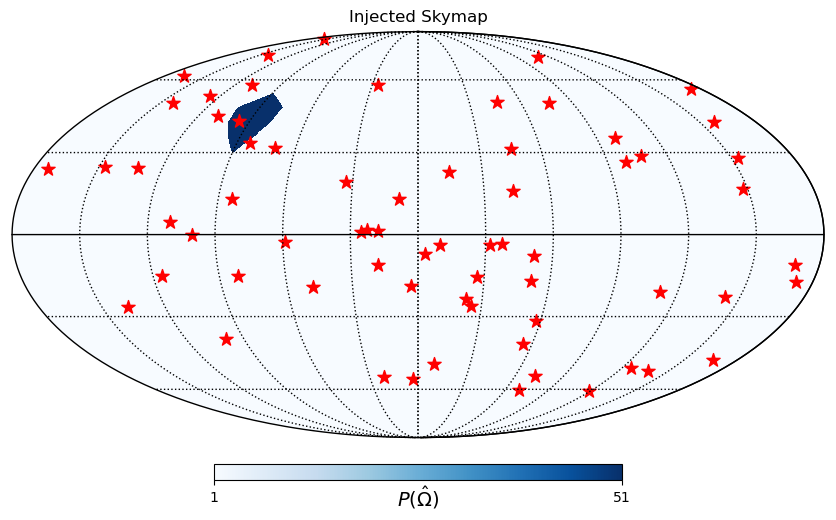

In [10]:
# Plot the injection
hp.mollview(input_map,title = 'Injected Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

### With our injection sorted, we now need to make data

Now that we have individual pixel powers, we can use a handy attribute from an anis_pta object.
The attribute in question, pta.F_mat, is the pixel basis design matrix for our correlations. What we can do with this is generate correlations from the product of this design matrix with the pixel power injection vector.

Note: We don't have to supply correlations upon creating an anis_pta object. If we choose not to, we can supply these after the fact with the pta.set_data(). 

In [11]:
#Initiate a PTA object without correlation values to gain access to some useful functions
pta = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = lmax,
                  mode = 'sqrt_power_basis', include_pta_monopole = False)

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


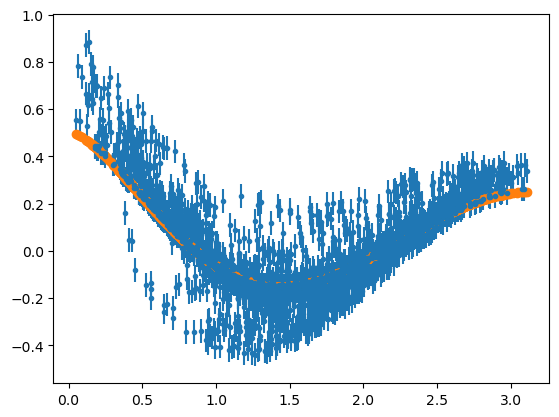

In [56]:
# Now create the simulated data from the basis function and the input map
synth_rho = pta.F_mat @ input_map #+ rng.normal(np.zeros(n_cc), syth_sig)
# While this simulation will not include noise, you could do so by adding a normal component
# with a standard deviation set by synth_sig.T


#Alternatively, you could simulate noisy correlations with mean given by HD curve, 
# and sigma by our choice above
#synth_rho = rng.normal(init_pta.get_pure_HD(), synth_sig) 


# Arbitrarily good choice for measurement uncertainty on the correlations
synth_sig = np.repeat(0.1, repeats = n_cc)


# Plot the data
plt.errorbar(pta.xi, synth_rho, yerr = synth_sig / 2, ls = '', marker = '.')
plt.plot(pta.xi, pta.get_pure_HD(), marker = 'o', ls = '')
plt.show()

## With our data generated, lets run the analysis

Our first step is to actually supply our anis_pta object with the data we generated

In [14]:
#Given our "PTA data", give the anis_pta object the correlations and their uncertainties
pta.set_data(synth_rho, synth_sig, 1)

### 1. Frequentist Inference

To get the maximum likelihood square root power, we can use the pta.max_lkl_sqrt_power() function!
This function returns and lmfit minimizer object with the minimized solution contained within. This can be helpful in cases where you may need to do some post-processing

In [15]:
lm_out = pta.max_lkl_sqrt_power()
print(lm_out.message)

lm_out.params

Fit succeeded.


name,value,standard error,relative error,initial value,min,max,vary
log10_A2,0.12663147,0.00175741,(1.39%),0.23662041330029987,-2.00000000,2.00000000,True
b_00,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False
b_10,-0.22269660,0.04008621,(18.00%),-0.7786617744171784,-inf,inf,True
b_11_amp,0.19140549,0.02400613,(12.54%),0.9434040879838967,0.00000000,inf,True
b_11_phase,1.56655559,0.14178362,(9.05%),3.2336032030765156,0.00000000,6.28318531,True
b_20,0.38833656,0.05188880,(13.36%),0.10026110833060997,-inf,inf,True
b_21_amp,1.24951863,0.06563034,(5.25%),2.6207778270422404,0.00000000,inf,True
b_21_phase,4.70414756,0.02665220,(0.57%),1.0969000763992114,0.00000000,6.28318531,True
b_22_amp,0.81411904,0.04986530,(6.13%),2.4008936358641333,0.00000000,inf,True
b_22_phase,3.25368836,0.04170983,(1.28%),2.4332724324628106,0.00000000,6.28318531,True


In [16]:
#Extract best fit b_lm params as a numpy array
lm_params = np.array(list(lm_out.params.valuesdict().values()))
lm_params_err = np.array([param.stderr for param in list(lm_out.params.values())])


### 2. Bayesian Inference with PTMCMC

First, set an output directory for ptmcmc. Then setup the ptmcmc sampler using the ```set_ptmcmc``` function in the anis_pt object.

The priors here are set internally. The type of priors can be specified by the 'prior_form' argument. Currently, it accepts 'Uniform', 'Normal' or 'TruncNormal'. Also, one can pass the min, max prior boundaries and mu, sigma when using 'Normal' or 'TruncNormal'. One can access these priors with <span style="color:blue">priors</span> attribute of anis_pta object. Also, note that we can pickle the anis_pta object using the 'save_anis_pta' flag to the outdir for better post-processing.

Note that here we don't run inference with bilby. To look at how to do that, refer to the ```./Bayesian_inference/example_linear_spherical_harmonics``` notebook.

In [17]:
### set an output directory for ptmcmc
ptmcmc_outdir = './ptmcmc/'

In [18]:
### Setup the ptmcmc sampler.
ptmcmc_sampler = pta.set_ptmcmc(prior_form='Uniform', log10_A2_prior_min=-2, log10_A2_prior_max=2,
                                bl0_prior_min=-5, bl0_prior_max=5, 
                                blm_amp_prior_min=0, blm_amp_prior_max=5, 
                                blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586,
                                outdir=ptmcmc_outdir, resume=True, save_anis_pta=True)

In [19]:
# sampler for N steps
N = int(1e6)
x0 = np.array([p.sample() for p in pta.priors])

In [20]:
### let's sample
ptmcmc_sampler.sample(x0, N, SCAMweight=30, AMweight=10, DEweight=50)

Finished 0.00 percent (0.00 percent of new work) in 0.001417 s Acceptance rate = 0

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent (1.00 percent of new work) in 4.522301 s Acceptance rate = 0.214578Adding DE jump with weight 50
Finished 100.00 percent (100.00 percent of new work) in 448.572105 s Acceptance rate = 0.220313
Run Complete


## Post processing

### Compare Frequentist and Bayesian inference results.

* First, we load the ptmcmc data and look at the trace-plot.

* Then compare the bayesian posterior samples with the best-fit parameters found with frequentist run using the corner-plot.

In [27]:
### For ptmcmc run
ptmcmc_core = core.Core(chaindir=ptmcmc_outdir, burn=0.45)

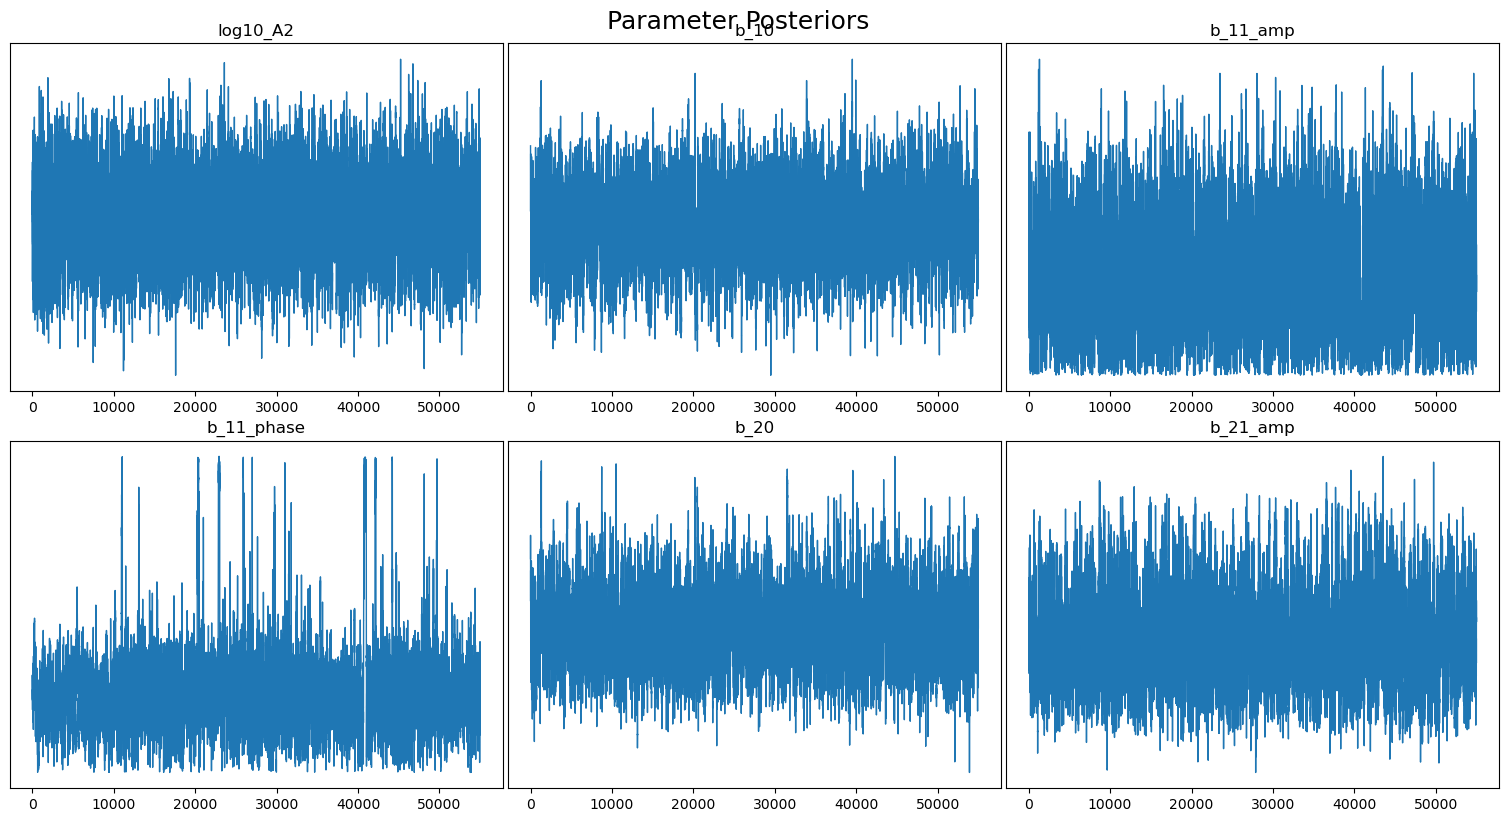

In [52]:
diagnostics.plot_chains(ptmcmc_core, hist=False, pars=pta.param_names[:6])

In [30]:
### Get array of samples to display a corner plot
ptmcmc_corner_params = ptmcmc_core.get_param(pta.param_names)

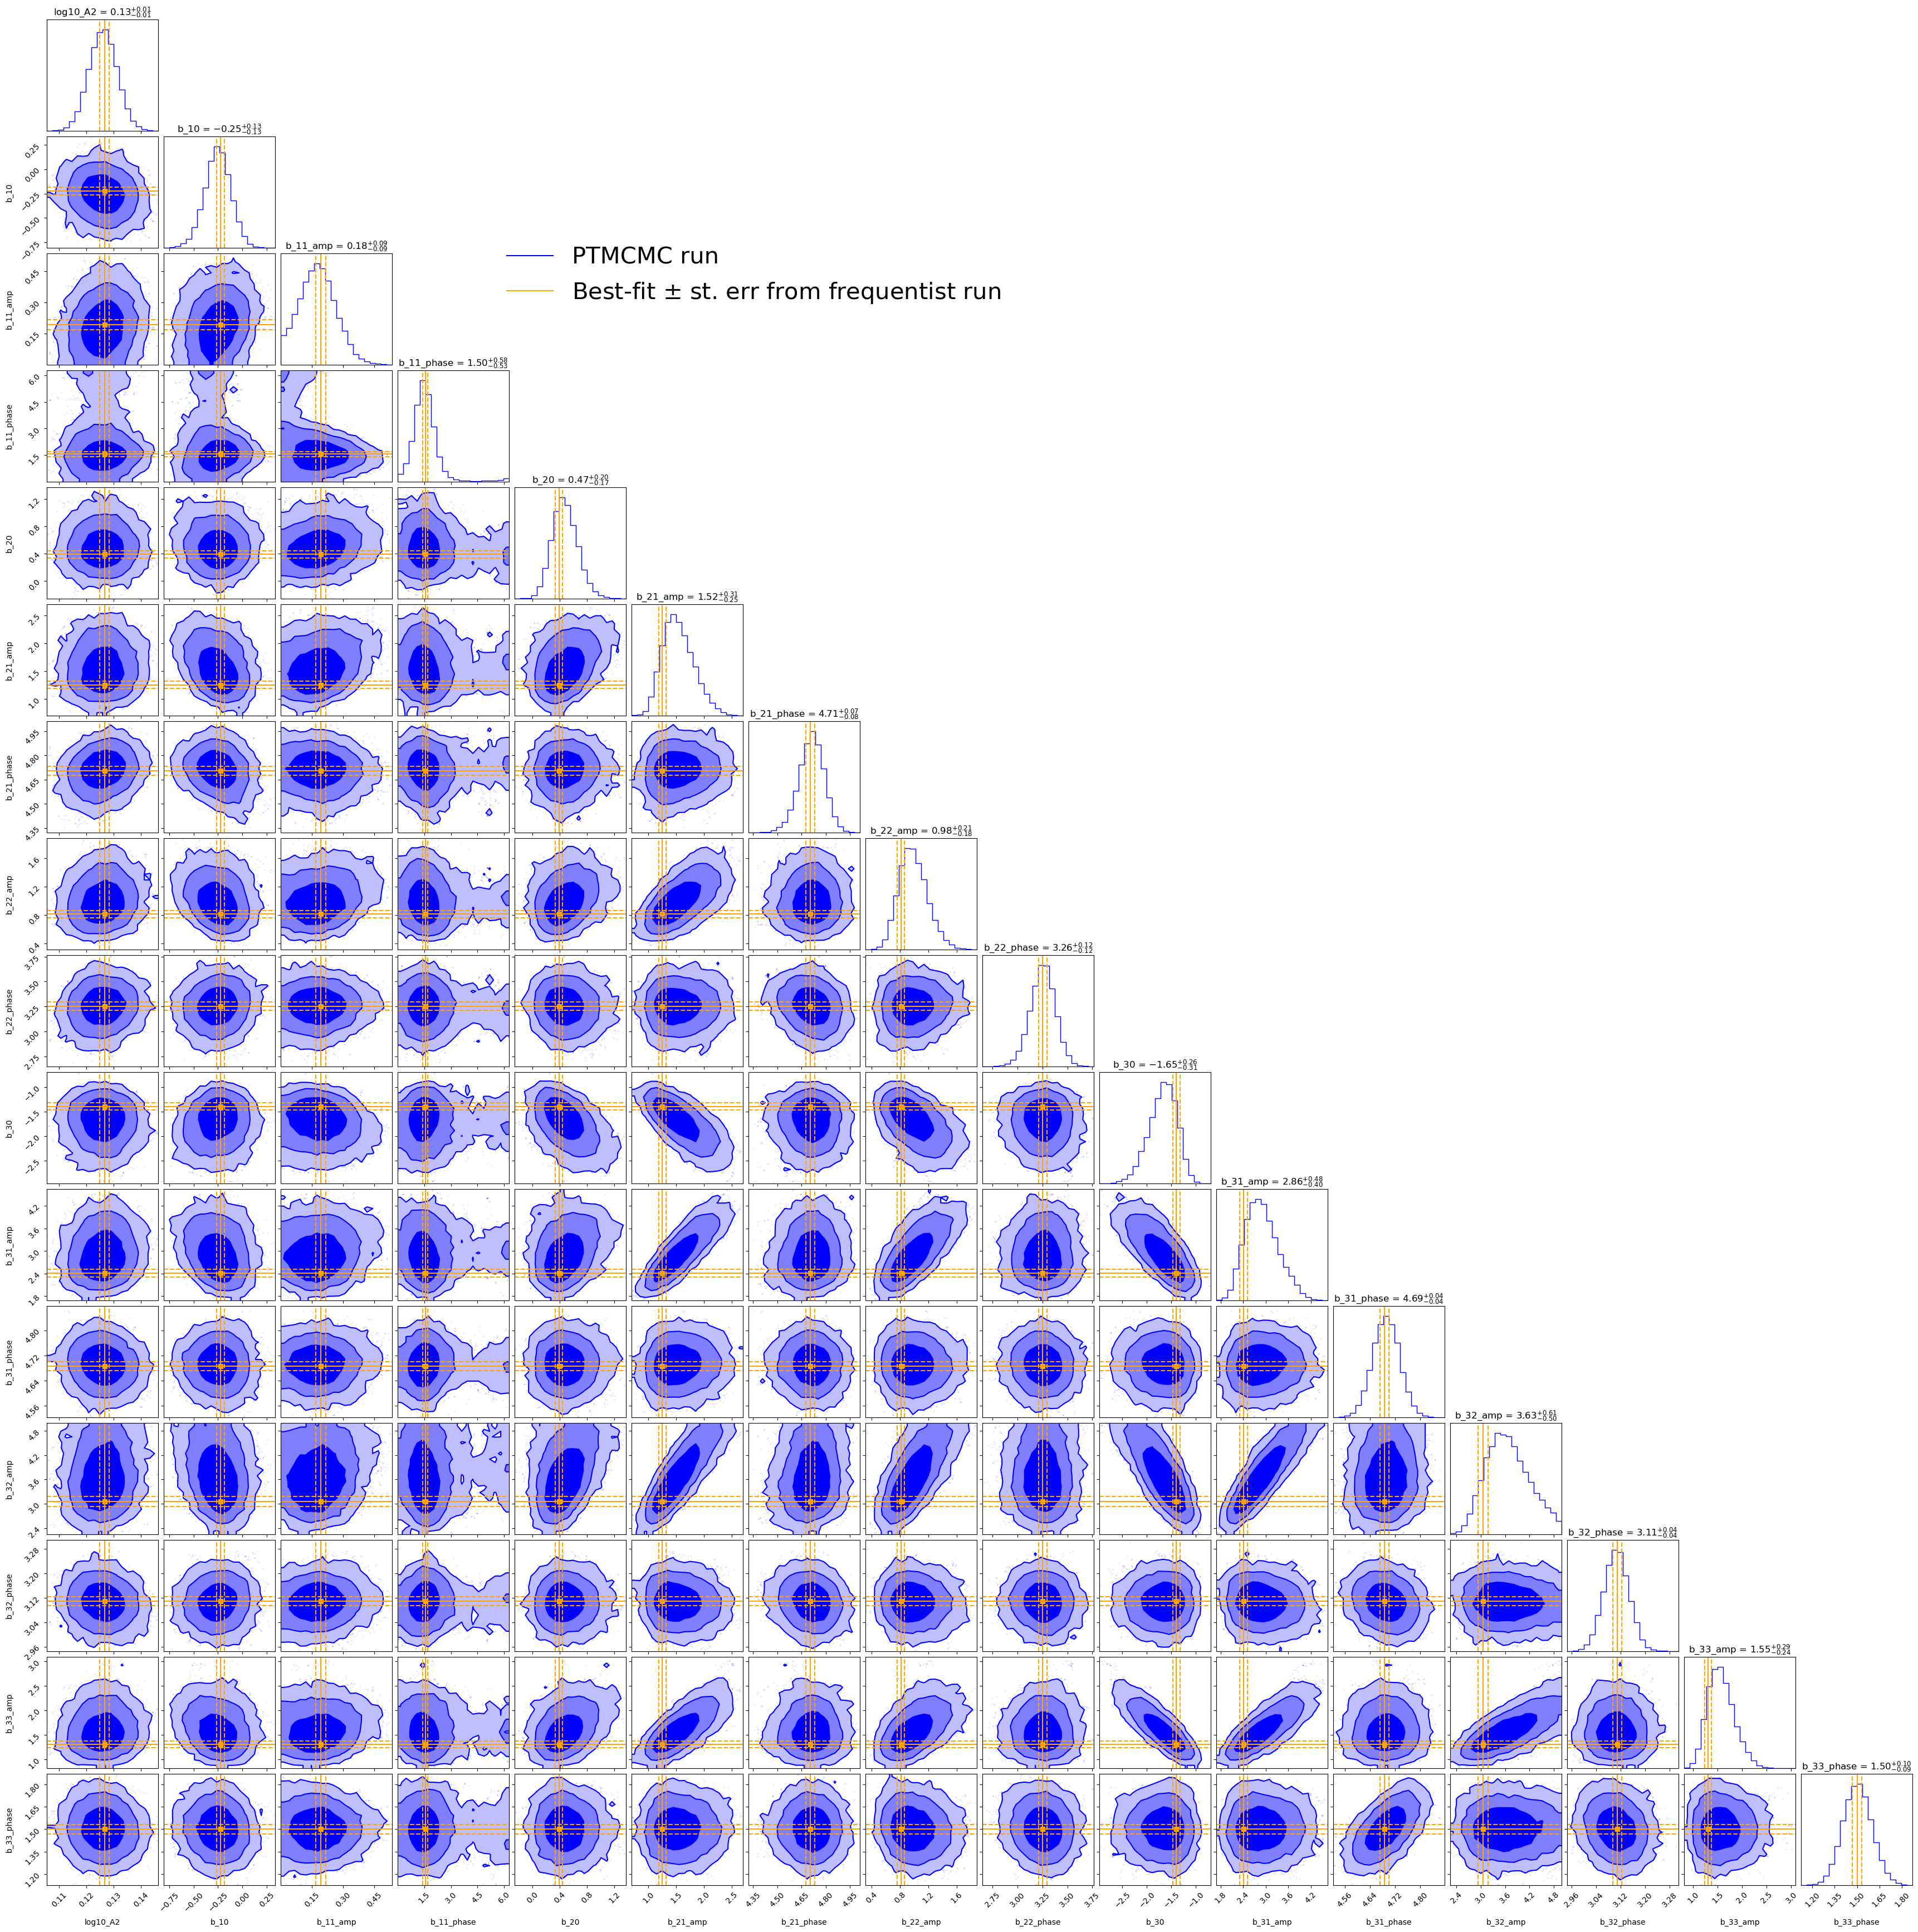

In [57]:
import matplotlib.lines as mlines

blue_line = mlines.Line2D([], [], color='blue', label=r'PTMCMC run')
orange_line = mlines.Line2D([], [], color='orange', label=r'Best-fit $\pm$ st. err from frequentist run')

fig = corner.corner(ptmcmc_corner_params, plot_datapoints=True, fill_contours=True, 
                    levels=[0.6827, 0.9545, 0.997], hist_kwargs={'color' : 'blue', 'density' : True}, color='blue', 
                    show_titles=True, labels=pta.param_names, truths=[lm_params[0], *lm_params[2:]], truth_color='orange')

corner.overplot_lines(fig=fig, xs=np.array([lm_params[0], *lm_params[2:]]) - np.array([lm_params_err[0], *lm_params_err[2:]]), 
                      color='orange', ls='--')

corner.overplot_lines(fig=fig, xs=np.array([lm_params[0], *lm_params[2:]]) + np.array([lm_params_err[0], *lm_params_err[2:]]), 
                      color='orange', ls='--')


plt.legend(handles=[blue_line, orange_line], frameon=False, bbox_to_anchor=(-8., 14., 1., .0), loc=4, fontsize=30)


plt.show()

#### Here, we see a very good agreement between bayesian and frequentist runs.

### Recovered power-map, $C_{l}$ and ORF.

* Frequentist recovered:

In [46]:
#Convert from the square-root spherical harmonic basis to spherical harmonic basis
lm_clm = utils.convert_blm_params_to_clm(pta, lm_params[1:])
input_clm = ac.clmFromMap_fast(input_map, lmax = lmax)

#Calculate the angular power spectrum in the spherical harmonic basis
Cl_freq = utils.angular_power_spectrum(lm_clm)
input_Cl = utils.angular_power_spectrum(input_clm)

#Calculate the best-fit ORF
orf_freq = 10**lm_params[0] * pta.orf_from_clm(lm_clm, include_scale=False)

#Translate the c_lm to a sky map
power_freq = 10 ** lm_params[0] * ac.mapFromClm(lm_clm, nside = pta.nside) #Note we model the amplitude in log-space

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


* Bayesian recovered: We need to obtain their samples using the  posterior samples. We use a handy funtion in utils to do so. ```utils.posterior_sampled_skymap_Cl_orf(pta, data, n_draws)``` return collection of power-maps, $C_{l}$, ORF randomly drawn from the given posteriors in data of shape ($N_{pars} \times N_{samples}$) where the number of draws are fixed by $n_{draws}$.

In [35]:
power_bayes_dist, Cl_bayes_dist, orf_bayes_dist = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=ptmcmc_corner_params.T, n_draws=5000)

n_draw: 100%|█████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.01it/s]


In [37]:
### Get the median of power-map, Cl and orf distribution
power_bayes = [np.median(power_bayes_dist[:, i]) for i in range(pta.npix)]
Cl_bayes = [np.median(Cl_bayes_dist[:, i]) for i in range(pta.l_max+1)]
orf_bayes = [np.median(orf_bayes_dist[:, i]) for i in range(pta.npairs)]

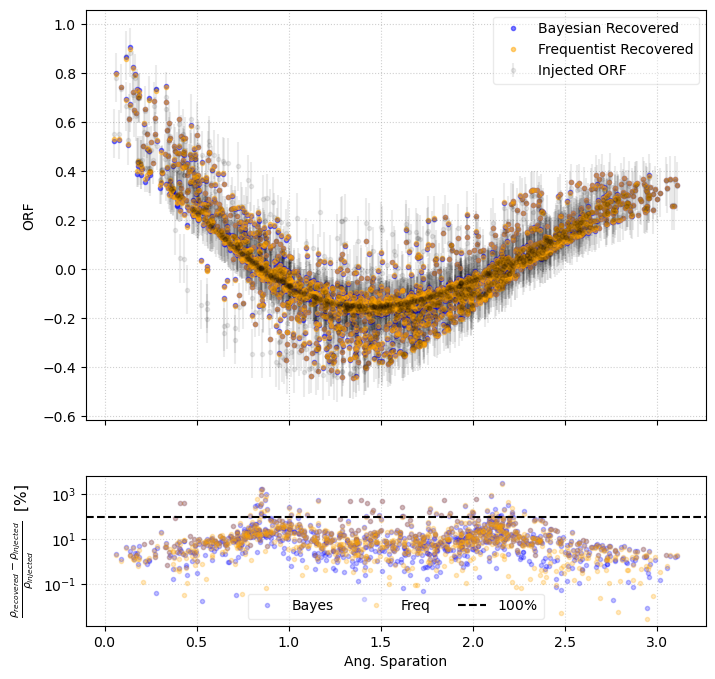

In [58]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(8, 8), sharex=True, height_ratios=[2.2, 0.8])


### Bilby ORF recovery
ax0.errorbar(pta.xi, synth_rho, synth_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax0.plot(pta.xi, orf_bayes, color='blue', ls='', marker='.', alpha=0.5, label='Bayesian Recovered')
ax0.plot(pta.xi, orf_freq, color='orange', ls='', marker='.', alpha=0.5, label='Frequentist Recovered')
ax0.set_ylabel(r"ORF")
ax0.legend(framealpha=0.4)
ax0.grid(ls=':', alpha=0.6)



### Relative difference in the recovered ORF
ax1.plot(pta.xi, (orf_bayes-synth_rho)/synth_rho * 100, ls='', 
             color='blue', marker='.', alpha=0.25, label='Bayes')
ax1.plot(pta.xi, (orf_freq-synth_rho)/synth_rho * 100, ls='', 
             color='orange', marker='.', alpha=0.25, label='Freq')

ax1.axhline(100, ls='--', label=r'$100\%$', color='black')
ax1.grid(ls=':', alpha=0.5)
ax1.set_yscale('log')
ax1.legend(framealpha=0.4, ncol=3)
ax1.set_ylabel(r'$\frac{\rho_{recovered} - \rho_{injected}}{\rho_{injected}}$  $[\%]$', fontsize=11)
ax1.set_xlabel(r'Ang. Sparation')



plt.show()

Next, lets compare our angular power spectrum recovery to what we injected

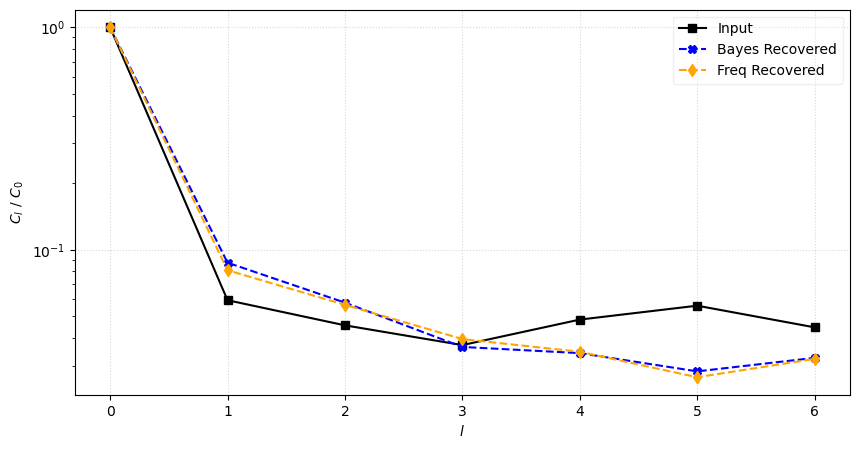

In [59]:
#Plot the angular power spectrum

plt.figure(figsize=(10, 5))

plt.plot(range(pta.l_max+1), input_Cl/input_Cl[0], color='black', marker='s', label='Input')
plt.plot(range(pta.l_max+1), Cl_bayes/Cl_bayes[0], color='blue', ls ='--', marker='X', label='Bayes Recovered')
plt.plot(range(pta.l_max+1), Cl_freq/Cl_freq[0], color='orange', ls ='--', marker='d', label='Freq Recovered')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_{l} \ / \ C_{0}$')

plt.yscale('log')

plt.legend(framealpha=0.3)
plt.grid(ls=':', alpha=0.5)


plt.show()

Now look into the SNRs

In [44]:
#Calculate the total, isotropic, and anisotropic S/N values

total_sn2, iso_sn2, anis_sn2 = utils.signal_to_noise(pta, lm_out)

# Notice that these values are squared SNRs! Keep that in mind!
total_sn = np.sqrt(total_sn2)
iso_sn = np.sqrt(iso_sn2)
anis_sn = np.sqrt(anis_sn2)

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


In [45]:
print('Total SNR:',total_sn, 'Isotropic SNR:', iso_sn, 'Anisotropic SNR:', anis_sn)

Total SNR: 96.58216092166862505 Isotropic SNR: 86.428913990377288085 Anisotropic SNR: 43.106341003883165978


Finally, we look at the recovered pixel power map.

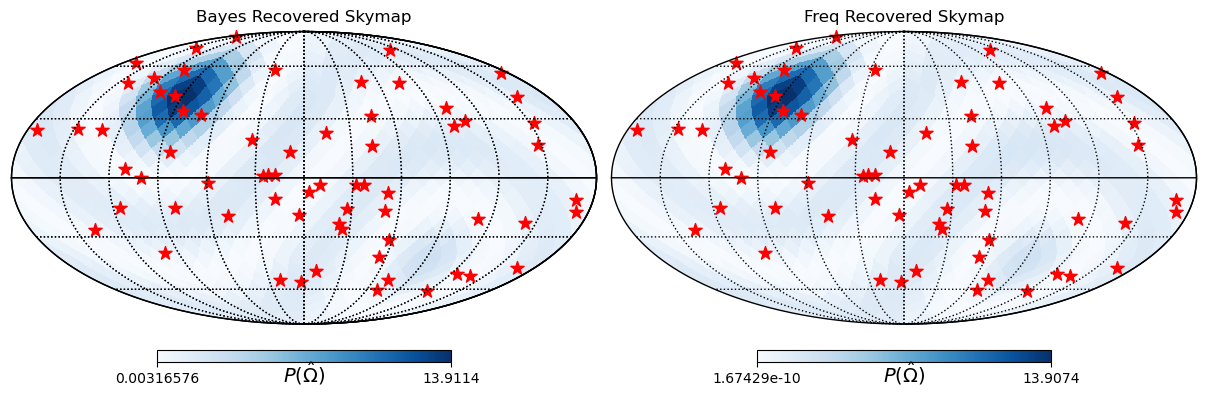

In [60]:
plt.figure(figsize=(12, 5))

hp.mollview(np.array(power_bayes), sub=(1, 2, 1), title = 'Bayes Recovered Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(power_freq, sub=(1, 2, 2), title = 'Freq Recovered Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.projscatter(pta.psrs_theta, pta.psrs_phi, color = 'red', marker = '*', s = 100)


plt.show()